<a href="https://colab.research.google.com/github/ashish-y/google-colab-transfer-learning/blob/main/EfficientNet_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from zipfile import ZipFile
file = "dataset.zip"

with ZipFile(file, 'r') as zip:
  zip.extractall()
  print('Done')


Done


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls "/content/drive/My Drive/Main/dataset"

test  train  validation


In [3]:
import os
#os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
import tensorflow as tf 
print(tf.__version__);
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
   print("Please install GPU version of TF")
import tensorflow.keras as keras
keras.__version__

2.3.0
Default GPU Device:/device:GPU:0


'2.4.0'

In [ ]:
import tensorflow.keras

In [4]:
#import tfkeras as ef
import tensorflow.keras.applications.efficientnet as ef
#import tensorflow.keras.applications.efficientnet as ef

In [5]:
input_size = 224

In [7]:
base_model =  ef.EfficientNetB7(input_shape=(input_size, input_size, 3), weights='imagenet',include_top=False)
#for layer in base_model.layers:
#    layer.trainable = False
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(3, activation='softmax')(x)
Model = tf.keras.models.Model(inputs=[base_model.input], outputs=[output])

In [8]:
Model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 224, 224, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 224, 224, 3)  7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization_1[0][0]            
_______________________________________________________________________________________

In [9]:
from tensorflow.keras import optimizers

In [10]:
#optim = optimizers.Nadam(lr=0.001,clipnorm=1)
optim = optimizers.Nadam(lr=0.00001)

In [11]:
from tensorflow.keras import backend as K
def F1_score(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (predicted_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    recall = recall(y_true, y_pred)
    precision = precision(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [12]:
Model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_path = '/content/drive/My Drive/Main/dataset/train'
valid_path = '/content/drive/My Drive/Main/dataset/validation'
test_path = '/content/drive/My Drive/Main/dataset/test'
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,vertical_flip=True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (input_size, input_size),
                                                 batch_size = 4,
                                                 class_mode = 'categorical')
print(training_set.class_indices)
test_set = test_datagen.flow_from_directory(valid_path,
                                            target_size = (input_size, input_size),
                                            batch_size = 4,
                                            class_mode = 'categorical')
print(test_set.class_indices)

Found 218 images belonging to 3 classes.
{'Close': 0, 'Open': 1, 'Unknown': 2}
Found 52 images belonging to 3 classes.
{'Close': 0, 'Open': 1, 'Unknown': 2}


In [17]:
checkpoint = keras.callbacks.ModelCheckpoint('best_model_B7_colab.h5', monitor="val_loss", verbose=1,
                                             save_best_only=True, save_weights_only=False, mode="min")
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [18]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs={}):
        if (logs.get('accuracy')>0.96):
            print("Reached 96% accuracy so cancelling training!")
            self.model.stop_training=True
callbacks = myCallback()

In [19]:
history = Model.fit( training_set, validation_data=test_set, epochs=50, 
                    steps_per_epoch=len(training_set), validation_steps=len(test_set),
                   callbacks=[checkpoint,es])

Epoch 1/50
55/55 [==============================] - ETA: 0s - loss: 1.1004 - accuracy: 0.3853

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "



Epoch 00001: val_loss improved from inf to 1.18985, saving model to best_model_B7_colab.h5
55/55 [==============================] - 104s 2s/step - loss: 1.1004 - accuracy: 0.3853 - val_loss: 1.1899 - val_accuracy: 0.2885
Epoch 2/50
55/55 [==============================] - ETA: 0s - loss: 0.9458 - accuracy: 0.6284
Epoch 00002: val_loss improved from 1.18985 to 1.18938, saving model to best_model_B7_colab.h5
55/55 [==============================] - 39s 703ms/step - loss: 0.9458 - accuracy: 0.6284 - val_loss: 1.1894 - val_accuracy: 0.2885
Epoch 3/50
55/55 [==============================] - ETA: 0s - loss: 0.8420 - accuracy: 0.7110
Epoch 00003: val_loss did not improve from 1.18938
55/55 [==============================] - 34s 625ms/step - loss: 0.8420 - accuracy: 0.7110 - val_loss: 1.2443 - val_accuracy: 0.2885
Epoch 4/50
55/55 [==============================] - ETA: 0s - loss: 0.7479 - accuracy: 0.7936
Epoch 00004: val_loss did not improve from 1.18938
55/55 [============================

In [ ]:
Model.save_weights('model_weights.h5')
Model.save('model.h5')
print("model saved")

model saved


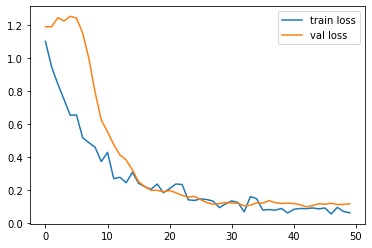

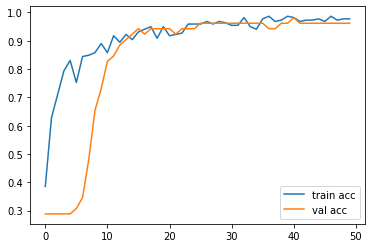

KeyError: ignored

In [20]:
# loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
# plt.savefig('LossVal_loss')

# accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
# plt.savefig('AccVal_acc')

# F1 score
plt.plot(history.history['F1_score'], label='train F1')
plt.plot(history.history['val_F1_score'], label='val F1')
plt.legend()
plt.show()
# plt.savefig('F1Val_F1')

In [21]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
loaded_model = load_model('best_model_B7_colab.h5')

In [23]:
class_name = {'1':'Close', '2': 'Open', '3': 'Unknown'}

In [24]:
#prediction
#prediction
import numpy as np
import glob
paths = glob.glob('/content/drive/My Drive/Main/dataset/ball_valve/*/*.*')
# print(paths)
import cv2
# img_pred = image.load_img(path, target_size=(150, 150))
# img_pred = image.img_to_array(img_pred)
# img_pred = np.expand_dims(img_pred, axis=0)
#images = np.vstack([img_pred])
for path in paths:
    image = cv2.imread(path)
    image = cv2.resize(image, (224, 224))
    image = image/255
    rslt = loaded_model.predict(np.array([image]))
    print(rslt)
#     print(np.argmax(rslt))
    print(path)
    print(class_name[str(np.argmax(rslt)+1)])

[[0.08085168 0.68997234 0.22917593]]
/content/drive/My Drive/Main/dataset/ball_valve/open/webcam_4.png
Open
[[0.04442567 0.80670834 0.14886606]]
/content/drive/My Drive/Main/dataset/ball_valve/open/webcam_5.png
Open
[[0.00779807 0.97832686 0.01387505]]
/content/drive/My Drive/Main/dataset/ball_valve/open/webcam_0.png
Open
[[0.00694051 0.9803406  0.0127188 ]]
/content/drive/My Drive/Main/dataset/ball_valve/open/webcam_1.png
Open
[[0.13816507 0.73402655 0.12780836]]
/content/drive/My Drive/Main/dataset/ball_valve/open/webcam_3.png
Open
[[0.12226136 0.65830356 0.2194351 ]]
/content/drive/My Drive/Main/dataset/ball_valve/open/webcam_6.png
Open
[[0.06421714 0.849823   0.08595979]]
/content/drive/My Drive/Main/dataset/ball_valve/open/webcam_7.png
Open
[[0.95498836 0.00625284 0.03875881]]
/content/drive/My Drive/Main/dataset/ball_valve/close/close_2.png
Close
[[0.8915531  0.01349368 0.09495322]]
/content/drive/My Drive/Main/dataset/ball_valve/close/close_3.png
Close
[[0.90204936 0.00490628 0.

In [25]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [27]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
loaded_model = load_model('best_model_B7_colab.h5')

<IPython.core.display.Javascript object>

Saved to photo.jpg
[[0.10767137 0.05053455 0.84179413]]
/content/drive/My Drive/Main/dataset/ball_valve/close/close_13.png
Unknown


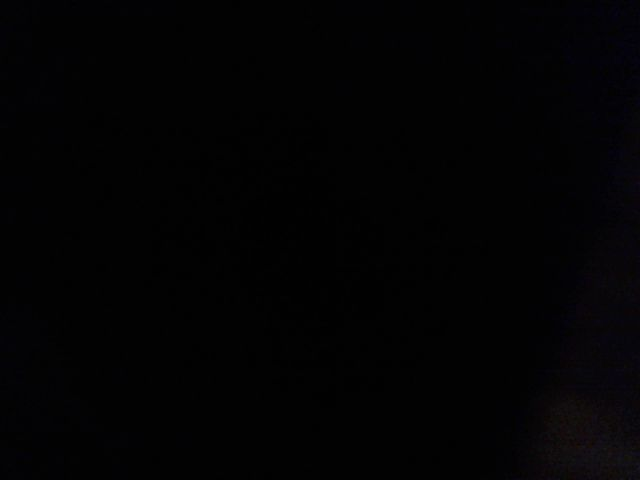

In [30]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  image = cv2.imread(filename)
  image = cv2.resize(image, (224, 224))
  image = image/255
  rslt = loaded_model.predict(np.array([image]))
  print(rslt)
  print(path)
  print(class_name[str(np.argmax(rslt)+1)])
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))